In [1]:
from phi.torch.flow import *
import pylab

In [2]:
bound = Box(x=(0, 80), y=(0, 120))
res = spatial(x=80, y=120)

In [3]:
INFLOW_LOCATION = tensor([(12, 4), (13, 6), (14, 5), (16, 5)], batch('inflow_loc'), channel(vector="x,y"))

# INFLOW_LOCATION = tensor((12, 4), channel(vector="x,y"))
INFLOW = (1. / 3.) * CenteredGrid(values=Sphere(center=INFLOW_LOCATION, radius=3), bounds=bound, resolution=res,
                                  extrapolation=extrapolation.BOUNDARY)
smoke = CenteredGrid(values=0, bounds=bound, resolution=res, extrapolation=extrapolation.BOUNDARY)
velocity = StaggeredGrid(values=0, bounds=bound, resolution=res, extrapolation=extrapolation.ZERO)

In [4]:
@jit_compile
def step(smoke, velocity):
    smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
    buoyancy_force = (smoke * (0, 1)).at(velocity)
    velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
    velocity, _ = fluid.make_incompressible(velocity)
    return smoke, velocity

C:\Users\imeho\AppData\Roaming\Python\Python311\site-packages\phiml\backend\torch\_torch_backend.py:800: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


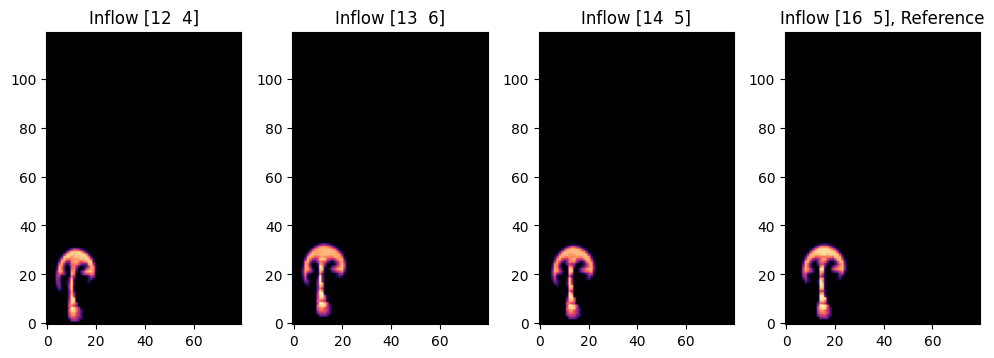

In [5]:
for _ in range(20):
    smoke, velocity = step(smoke, velocity)

smoke_final = smoke
fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
    axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i, ...], origin='lower', cmap='magma')
    axes[i].set_title(f"Inflow {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}" + (", Reference" if i == 3 else ""))
pylab.tight_layout()